<a href="https://colab.research.google.com/github/shahabhi25/facial-expression-recognition/blob/master/Facial_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhisheksmith","key":"76434e46713f304219a351c3f1070159"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge             COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-06-05 02:43:46          71785  
roche-data-science-coalition/uncover                          UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10483  
jessicali9530/animal-crossing-new-horizons-nookplaza-dataset  Animal Crossing New Horizons NookPlaza Catalog      577KB  2020-05-18 22:50:26             42  
biancaferreira/african-wildlife                               African Wildlife                                    448MB  2020-05-25 13:42:19              2  
siddharthm1698/coursera-course-dataset              

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 80% 77.0M/96.6M [00:00<00:00, 80.1MB/s]
100% 96.6M/96.6M [00:00<00:00, 104MB/s] 
 47% 9.00M/19.3M [00:00<00:00, 43.1MB/s]
100% 19.3M/19.3M [00:00<00:00, 64.5MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.16MB/s]
 78% 60.0M/77.3M [00:00<00:00, 77.8MB/s]
100% 77.3M/77.3M [00:00<00:00, 92.5MB/s]
 87% 80.0M/92.0M [00:01<00:00, 64.5MB/s]
100% 92.0M/92.0M [00:01<00:00, 83.2MB/s]


In [ ]:
! unzip /content/train.csv.zip
! unzip /content/test.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                


In [ ]:
!kaggle datasets download -d deadskull7/fer2013

 97% 94.0M/96.6M [00:01<00:00, 86.7MB/s]
100% 96.6M/96.6M [00:01<00:00, 83.2MB/s]


In [ ]:
! unzip /content/fer2013.zip

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


In [ ]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
import os 
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [ ]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [ ]:
train_data.shape

(28709, 2)

In [ ]:
test_data.shape

(7178, 1)

In [ ]:
X_train = np.array(pd.Series(train_data["pixels"]).str.split(expand = True)).astype(float).reshape((28709, 48, 48, 1))
Y_train = np.array(pd.Series(train_data["emotion"])).astype(float).reshape((28709, 1))

X_test = np.array(pd.Series(test_data["pixels"]).str.split(expand = True)).astype(float).reshape((-1, 48, 48, 1))


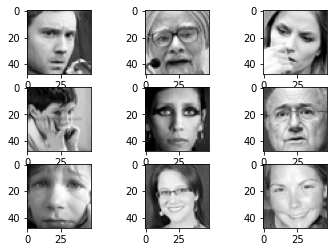

In [ ]:
for i in range(0, 9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i].reshape((48, 48)), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
import keras as k
y_train = k.utils.np_utils.to_categorical(Y_train)

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
X_train.shape[:]

(28709, 48, 48, 1)

In [ ]:
from sklearn.model_selection import train_test_split as TTS
X_train1, X_test1, y_train1, y_test1 = TTS(X_train, y_train, test_size=0.03, random_state=0)

Building the model

In [ ]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
               

In [ ]:
callbacks = myCallback()

In [ ]:
#Identity Block
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid',
               name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same',
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid',
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding = 'valid',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + '2b', padding = 'same',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), name = conv_name_base + '2c', padding = 'valid',
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid',
               kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
def ResNet50(input_shape, classes):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    #X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    #X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    #X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    #X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    #X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    #X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    #X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    #X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    #X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    #X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    #X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    #X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    #X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(X_train.shape[1:], classes = 7)

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#model.fit(x = X_train1, y = y_train1, epochs = 10, batch_size = 256, callbacks = [callbacks])

In [ ]:
X_train1, X_test1, y_train1, y_test1 = TTS(X_train, y_train, test_size=0.03, random_state=0)

# Data augmentation

datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train1)


model.fit_generator(datagen.flow(X_train1, y_train1, batch_size=32), steps_per_epoch = len(X_train1) / 32, epochs = 50, callbacks = [callbacks])



Epoch 1/50
871/870 [==============================] - 45s 52ms/step - loss: 1.9593 - accuracy: 0.2541
Epoch 2/50
871/870 [==============================] - 37s 43ms/step - loss: 1.6376 - accuracy: 0.3503
Epoch 3/50
871/870 [==============================] - 37s 43ms/step - loss: 1.5143 - accuracy: 0.4106
Epoch 4/50
871/870 [==============================] - 37s 43ms/step - loss: 1.4272 - accuracy: 0.4494
Epoch 5/50
871/870 [==============================] - 37s 43ms/step - loss: 1.3661 - accuracy: 0.4760
Epoch 6/50
871/870 [==============================] - 37s 43ms/step - loss: 1.3254 - accuracy: 0.4968
Epoch 7/50
871/870 [==============================] - 38s 43ms/step - loss: 1.2918 - accuracy: 0.5080
Epoch 8/50
871/870 [==============================] - 37s 43ms/step - loss: 1.2632 - accuracy: 0.5201
Epoch 9/50
871/870 [==============================] - 37s 43ms/step - loss: 1.2385 - accuracy: 0.5270
Epoch 10/50
871/870 [==============================] - 37s 43ms/step - loss: 1.217

In [ ]:
preds = model.evaluate(x = X_test1, y = y_test1, use_multiprocessing=True, workers=3 )

862/862 [==============================] - 0s 325us/step


In [ ]:
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loss = 0.9937001079528348
Test Accuracy = 0.639211118221283


In [ ]:
 model.save("lower_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving WIN_20200419_16_04_46_Pro (2).jpg to WIN_20200419_16_04_46_Pro (2).jpg


{'WIN_20200419_16_04_46_Pro (2).jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xe1A<Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x07\x00\x0b\x00\x02\x00\x00\x00&\x00\x00\x08n\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x011\x00\x02\x00\x00\x00&\x00\x00\x08\x94\x012\x00\x02\x00\x00\x00\x14\x00\x00\x08\xba\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08\xce\x88%\x00\x04\x00\x00\x00\x01\x00\x00\x11&\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00b\x00\x00!F\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(504, 504)
(48, 48)


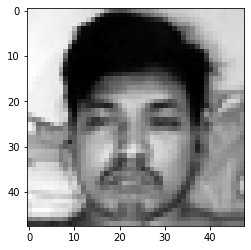

In [ ]:
from PIL import Image
from keras.preprocessing.image import img_to_array

img = Image.open('WIN_20200419_16_04_46_Pro (2).jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
img = img.resize((48, 48)).convert('L')
print(img.size)
# show the image
img.show()

img_array = image.img_to_array(img)
#print(img_array)
plt.imshow(img_array.reshape((48, 48)), cmap=plt.get_cmap('gray'))

In [ ]:
img_array = np.expand_dims(img_array, axis=0)
x = img_array/255.0
prediction = model.predict(x)

In [ ]:
print(prediction)

[[0.09661712 0.00245751 0.11722084 0.08088332 0.11982178 0.00370886
  0.57929057]]


In [ ]:
dataset = pd.read_csv('/content/fer2013.csv')

In [ ]:
test = np.array(pd.Series(dataset[dataset['Usage']=='PublicTest']["pixels"]).str.split(expand = True)).astype(float).reshape((3589, 48, 48, 1))
test_label = np.array(pd.Series(dataset[dataset['Usage']=='PublicTest']["emotion"])).astype(float).reshape((3589, 1))

In [ ]:
 test = test/255
 test_label = k.utils.np_utils.to_categorical(test_label)

In [ ]:
preds = model.evaluate(x = test, y = test_label, use_multiprocessing=True, workers=3 )

3589/3589 [==============================] - 2s 451us/step


In [ ]:
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loss = 1.0542174669386917
Test Accuracy = 0.6177208423614502


In [ ]:
dev_set = dataset[dataset['Usage']=='PublicTest']
dev_set = dev_set.reset_index(drop=True)
X_dev,Y_dev = dev_set['pixels'],dev_set['emotion']
X_dev2 = np.zeros((X_dev.shape[0],48*48)) 
for i in range(X_dev2.shape[0]):
    p = X_dev[i].split(' ')
    for j in range(X_dev2.shape[1]):
        X_dev2[i][j] = int(p[j])
Y_dev2 = np.array(Y_dev)
X_dev3 = X_dev2.reshape(X_dev2.shape[0],48,48)
Y_dev = Y_dev2
X_dev = X_dev3